# PYNAMESTATE

this is a engine to convert data from the SSI name index into a format suitable for clustering states and years on the basis of how similar names were from state to state and year to year.  Notebook assumes you're loading from an enviroment with python3, numpy, pandas, matplotlib, and scikit. 

data used here downloaded from: https://www.ssa.gov/OACT/babynames/state/namesbystate.zip

#### existing code does the following: 
- loads data from raw .csv into dataframe (converted from .txt in ssi zip)
- concatinates dataframes from each file into a larger dataframe
- imputes missing names (it'd be nice to have all names per year per state per gender to make something nice and matrix-y later on)
- calculates a score based on the fraction of births/year with a given name
- calculates similarity between states and years based on name freqency
- reduces the number of observed variables (i.e. names) via PCA
- clusters states in a given year based on similarity
- displays heatmap and scatter of clustering

In [27]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import glob

# assuming you're running the notebook where the data is
#os.chdir('namesbystate')
cwd = os.getcwd()

# find all the *.csv files locally and put them into a list (os.path.join)
# and do it with 'nix naming conventions (glob.glob)
all_files = glob.glob(os.path.join(cwd, "*.csv"))    

# read each file in all_files into a dataframe with proper headers, and concatinate to larger dataframe
df = pd.concat(pd.read_csv(f, names = ["state", "gender", "year", "name", "nbirths"]) for f in all_files)

# display the result, see if it looks like the dataframe we want
print(df[1:15])



   state gender  year       name  nbirths
1     AK      F  1910      Annie       12
2     AK      F  1910       Anna       10
3     AK      F  1910   Margaret        8
4     AK      F  1910      Helen        7
5     AK      F  1910      Elsie        6
6     AK      F  1910       Lucy        6
7     AK      F  1910    Dorothy        5
8     AK      F  1911       Mary       12
9     AK      F  1911   Margaret        7
10    AK      F  1911       Ruth        7
11    AK      F  1911      Annie        6
12    AK      F  1911  Elizabeth        6
13    AK      F  1911      Helen        6
14    AK      F  1912       Mary        9


In [28]:
# drop the boys
df = df[df.gender !='M']
df = df.drop('gender',1)

# take names with reasonable frequency
df = df[df.nbirths>9]

# take a small subset of years
# aids in fitting in system memory

years = range(1935,2011,25)
df = df.loc[df['year'].isin(years)]

print(df[1:15])



     state  year       name  nbirths
527     AK  1935  Elizabeth       13
528     AK  1935   Margaret       13
2783    AK  1960       Mary       78
2784    AK  1960      Linda       56
2785    AK  1960      Karen       53
2786    AK  1960      Debra       50
2787    AK  1960      Susan       50
2788    AK  1960  Elizabeth       47
2789    AK  1960     Sandra       47
2790    AK  1960   Patricia       43
2791    AK  1960      Donna       42
2792    AK  1960      Cindy       40
2793    AK  1960     Cheryl       39
2794    AK  1960     Teresa       39
2842
that seems like a lot of missing rows



In [29]:
# to end with a 50 x n_names matrix of similarity to classify on
# it'd be nice to fill in birth #'s for missing names (for that year,state)
# this is not particularly fast, roughly 5 minutes per year - slower if we're more inclusive with rare names

# first, deliniate how the dataframe is structured
level_index = ['state','year','name']

# then establish how a full (n_states x n_years x n_names) dataframe would be structured
full_index = pd.MultiIndex.from_product([df[col].unique() for col in level_index], names=level_index)

#then, re-index first dataframe in the larger, fully indexed dataframe
df = df.set_index(level_index).reindex(full_index)

# finally, for all new cells of the dataframe, set nbirths as 0 for names not born in that year and state
df = df.groupby(level = level_index).fillna(value=0).reset_index()

# now, the dataframe should include 'new' names for each year, state
print(df[1:15])

   state  year       name  nbirths
1     AK  1935  Elizabeth     13.0
2     AK  1935   Margaret     13.0
3     AK  1935      Linda      0.0
4     AK  1935      Karen      0.0
5     AK  1935      Debra      0.0
6     AK  1935      Susan      0.0
7     AK  1935     Sandra      0.0
8     AK  1935   Patricia      0.0
9     AK  1935      Donna      0.0
10    AK  1935      Cindy      0.0
11    AK  1935     Cheryl      0.0
12    AK  1935     Teresa      0.0
13    AK  1935    Cynthia      0.0
14    AK  1935      Nancy      0.0


In [73]:
# let's calculate the measure by which we'll look at state, year similarity

# find the number of births that year, and calculate a ratio based on nbirths/totalbirths
df['nbirthsum'] = df.groupby(["state","year"])["nbirths"].transform(np.sum)
df['nbirthratio'] = df["nbirths"]/df["nbirthsum"]

# now with the addition of our nbirthratio
print(df[1:15])

# we can access the values we want through the following logical indexing, for reference: 
print(df[(df.state == "MA") & (df.year == 1985) & (df.name == "Mary")]["nbirthratio"].values)


   state  year       name  nbirths  nbirthsum  nbirthratio
1     AK  1935  Elizabeth     13.0       55.0     0.236364
2     AK  1935   Margaret     13.0       55.0     0.236364
3     AK  1935      Linda      0.0       55.0     0.000000
4     AK  1935      Karen      0.0       55.0     0.000000
5     AK  1935      Debra      0.0       55.0     0.000000
6     AK  1935      Susan      0.0       55.0     0.000000
7     AK  1935     Sandra      0.0       55.0     0.000000
8     AK  1935   Patricia      0.0       55.0     0.000000
9     AK  1935      Donna      0.0       55.0     0.000000
10    AK  1935      Cindy      0.0       55.0     0.000000
11    AK  1935     Cheryl      0.0       55.0     0.000000
12    AK  1935     Teresa      0.0       55.0     0.000000
13    AK  1935    Cynthia      0.0       55.0     0.000000
14    AK  1935      Nancy      0.0       55.0     0.000000
[ 0.00536937]


In [74]:
# let's format the new nbirthratio into a state by name matrix for a given year (np.array)

import numpy as np

# first find the dimensions
state_index = df.state.unique()
name_index = df.name.unique()


# then, initialize the matrix
df_matrix = np.zeros((len(state_index), len(name_index)))

# then, let's populate the larger matrix
# note: this is SLOW (50ms per element!, 2h total)

for st in range(0, len(state_index)): 

    for na in range(0, len(name_index)):
    
        df_matrix[st, na] = df[(df.state == state_index[st]) & (df.year == 1985) & (df.name == name_index[na])]["nbirthratio"].values
    

print(df_matrix[1:10,1:10])

[[ 0.01509472  0.00269906  0.00144949  0.00219923  0.00054981  0.00209927
   0.00099965  0.0022992   0.00119958]
 [ 0.01468363  0.00186883  0.00088992  0.00169084  0.          0.00204681
   0.00115689  0.00240278  0.00142387]
 [ 0.01225314  0.00211427  0.00163375  0.00201816  0.00081688  0.00206621
   0.00216232  0.00422853  0.00086493]
 [ 0.01283534  0.00122339  0.0026267   0.00214865  0.00047291  0.0014033
   0.00353653  0.00381925  0.00060656]
 [ 0.01496247  0.00313168  0.00114331  0.00223691  0.00049709  0.00139186
   0.00139186  0.0026843   0.00084506]
 [ 0.01895341  0.00312699  0.00153159  0.00319081  0.          0.0023612
   0.00146777  0.00242502  0.        ]
 [ 0.02451725  0.00564114  0.          0.00216967  0.          0.00238663
   0.00282057  0.0052072   0.        ]
 [ 0.01533019  0.          0.          0.          0.          0.          0.
   0.0043239   0.        ]
 [ 0.01228369  0.00168471  0.00163564  0.00210998  0.00081782  0.00142301
   0.00219176  0.0035657   0.000

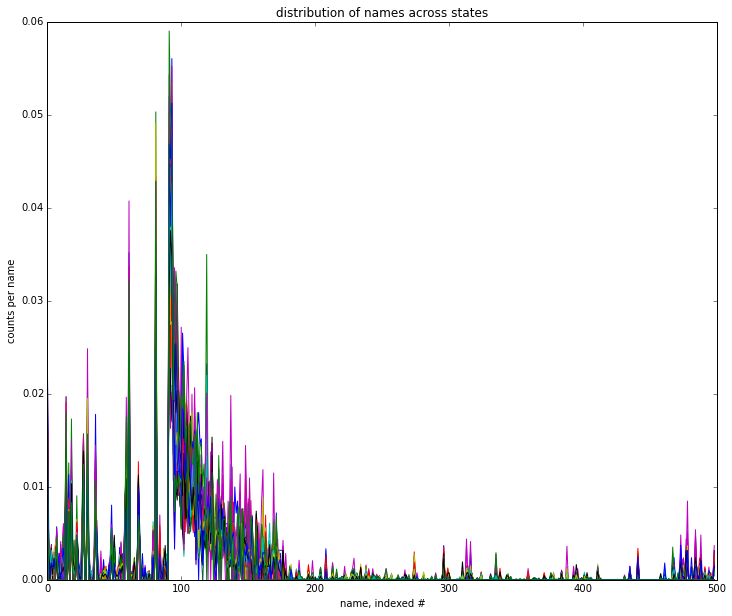

C:\Miniconda3\envs\rldm\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


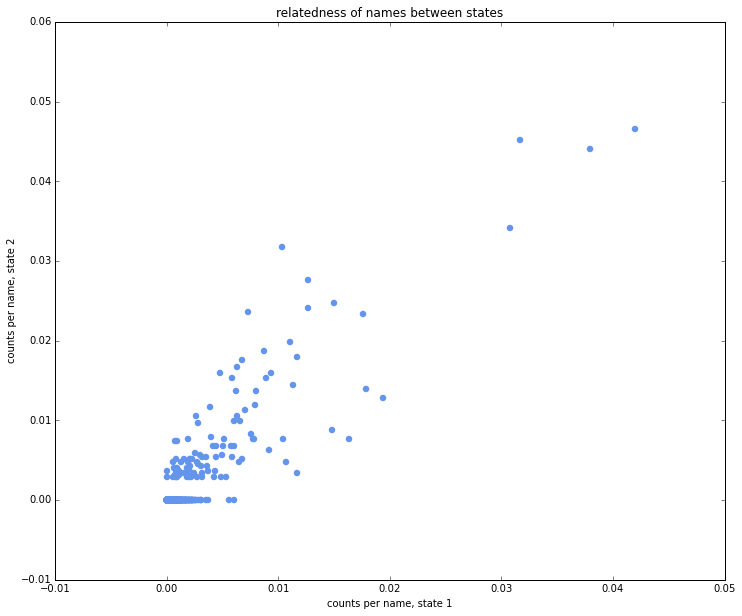

In [199]:
# make figures nicer by plotting inline
# and making those inline figures bigger

%matplotlib inline

import pylab
pylab.rcParams['figure.figsize'] = (12.0, 10.0)


## OK, so now that we have our matrix, let's 
## visualize the relatedness among states


# make a plot of name frequency across states
# showing modest differences, and broad correlations

plt.plot((df_matrix[:,1:500].T), linewidth = 1)
plt.xlabel('name, indexed #')
plt.ylabel('counts per name')
plt.title('distribution of names across states')

plt.show()
# make a scatter of two arbitrary states to show strong, but imperfect correlation

plt.scatter(df_matrix[10,:],df_matrix[41,:], color = 'cornflowerblue', linewidth = 2)
plt.xlabel('counts per name, state 1')
plt.ylabel('counts per name, state 2')
plt.title('relatedness of names between states')



plt.show()


C:\Miniconda3\envs\rldm\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


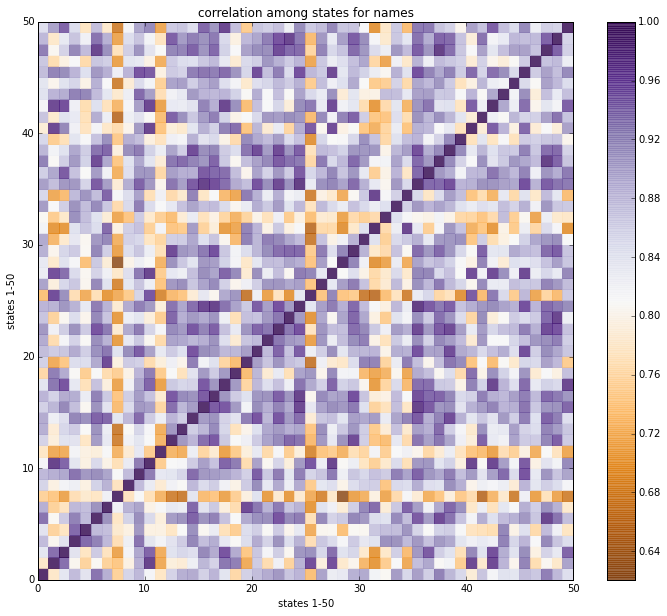

In [200]:
# let's see if all the states are the same - here we're ordered alphabetically

# calculate raw, un-normalized correlation coefficients 
# between each pair of states - normalization lowers correlation drastically

raw_state_corr=np.corrcoef(df_matrix)


# make a simple heatmap of states, ordered alphabetically

plt.pcolor(np.power(raw_state_corr,2), cmap=plt.cm.PuOr, alpha=0.8)

plt.colorbar()
plt.xlabel('states 1-50')
plt.ylabel('states 1-50')
plt.xlim([0, 50]), plt.ylim([0, 50])
plt.title('correlation among states for names')

plt.show()

C:\Miniconda3\envs\rldm\lib\site-packages\matplotlib\collections.py:590: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self._edgecolors == str('face'):


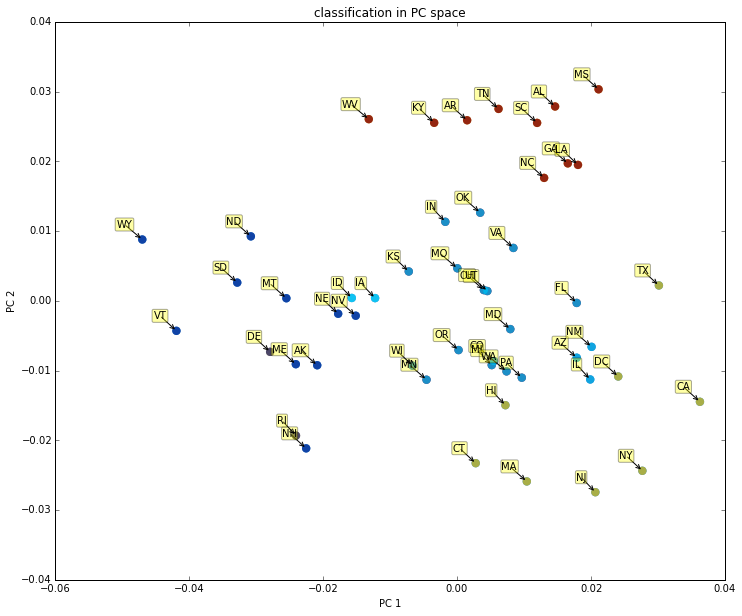

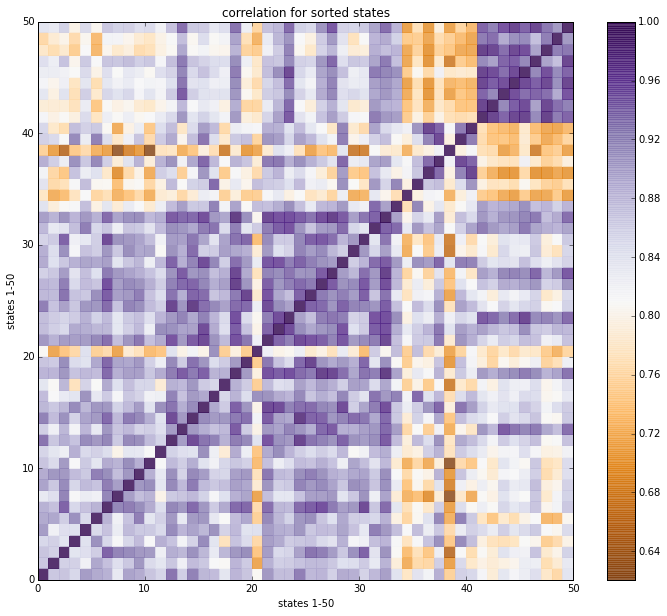

In [201]:
# let's see if all the states are the same - here we're clustered on the first few PC's
from sklearn.decomposition import PCA
from sklearn.cluster import AgglomerativeClustering


pca = PCA(n_components=50)
pca.fit(df_matrix)
X = pca.transform(df_matrix)

#plt.subplot(1,2,1)
for linkage in ('ward', 'average', 'complete'):
    model = AgglomerativeClustering(linkage=linkage, n_clusters=4)
    model.fit(X[:,0:3])
    plt.scatter(X[:, 0], X[:, 1], c=model.labels_, s=70, alpha = 0.6, edgecolor = 'None')
    
plt.xlabel('PC 1')
plt.ylabel('PC 2')
plt.xlim([-0.06, 0.04])
plt.ylim([-0.04, 0.04])
plt.title('classification in PC space')


for label, x, y in zip(state_index, X[:, 0], X[:, 1]):
    plt.annotate(
        label,
        xy=(x, y), xytext=(-10, 10),
        textcoords='offset points', ha='right', va='bottom',
        bbox=dict(boxstyle='round,pad=0.15', fc='yellow', alpha=0.35),
        arrowprops=dict(arrowstyle = '->', connectionstyle='arc3,rad=0'))


plt.show()


#plt.subplot(1,2,2)

cluster_order=np.argsort(model.labels_)
psort_state_corr=np.power(raw_state_corr[:,cluster_order],2)
sort_state_corr=np.power(raw_state_corr[cluster_order,:],1)

plt.pcolor(np.power(sort_state_corr[:,cluster_order],2), cmap=plt.cm.PuOr, alpha=0.8)
plt.colorbar()

plt.xlabel('states 1-50')
plt.ylabel('states 1-50')
plt.xlim([0, 50]), plt.ylim([0, 50])
plt.title('correlation for sorted states')

plt.show()



In [184]:
# let's list the groups - rural north, 
print(state_index[model.labels_ == 0])

# midwest tidewater and plains
print(state_index[model.labels_ == 1])

# costal states and southwest
print(state_index[model.labels_ == 2])

# southern states, plus mountains
print(state_index[model.labels_ == 3])

['AK' 'DE' 'ME' 'MT' 'ND' 'NE' 'NH' 'NV' 'RI' 'SD' 'VT' 'WY']
['AZ' 'CO' 'FL' 'IA' 'ID' 'IL' 'IN' 'KS' 'MD' 'MI' 'MN' 'MO' 'NM' 'OH' 'OK'
 'OR' 'PA' 'UT' 'VA' 'WA' 'WI']
['CA' 'CT' 'DC' 'HI' 'MA' 'NJ' 'NY' 'TX']
['AL' 'AR' 'GA' 'KY' 'LA' 'MS' 'NC' 'SC' 'TN' 'WV']
